# _**<span style="color:#1F618D;"> Face Mask Image Classification</span>**_

<span style="color:#148F77;">Author: Blaise Appolinary</span> [@Blaise](https://blaise-appolinary.netlify.app/)

******

<a id="table-of-contents"></a>
# **<span style="color:#1F618D;">📓 Table of Contents 📓</span>**
- [1.😼 About author](#1)
- [2. Background and Objective](#2)
- [3. Convolution Block Implementation](#3)
- [4. Classifier Implementation](#4)
- [5. Obtaining DataLoaders](#5)
- [6. Train Loop Implementation](#6)
- [7. Model Evaluation on Test set](#7)
******

<a id="1"></a>
# <span style="color:#1F618D;">😼 About Me</span>
My name is Blaise Appolinary, a Mathematics and Statistics student at the University of British Columbia. I love playing with datasets to gain insights from them through machine learning, statistical analysis and data visualization.


<a id="2"></a>
# <span style="color:#1F618D;">BackGround and Objective of the project</span>
The use of Masks have been very helpful in the fight against the rise of COVID-19 cases globally. The objective of the project is to build a Convolutional Neural Network architecture that can classify different images and detect whether the image has:
- a fully covered face by a mask
- a partially covered face by a mask
- a face not covered by mask
- No a face at all

<table style='font-size:10'>
    <tr>
    <th>Fully covered</th>
    <th>Partially Covered</th>
    <th>Not covered</th>
    <th>Not Face</th>
    </tr>
    </tr>
    <tr>
    <td> <img src="Images/fully_masked1.jpg" alt="Fully Masked" style="width: 70px;"/> </td>
    <td> <img src="Images/partially1.jpg" alt="Partially Masked" style="width: 70px;"/> </td>
    <td> <img src="Images/not_covered1.jpg" alt="Not Masked" style="width: 70px;"/> </td>
    <td> <img src="Images/not_face1.jpg" alt= "Not face" style='width:70px'"/> </td>
    </tr>
    <tr>
    <td> <img src="Images/fully_masked2.jpg" alt="Fully Masked" style="width: 70px;"/> </td>
    <td> <img src="Images/partially2.jpg" alt="Partially Masked" style="width: 70px;"/> </td>
    <td> <img src="Images/not_covered2.jpg" alt="Not Masked" style="width: 70px;"/> </td>
    <td> <img src="Images/not_face2.jpg" alt= "Not face" style='width:70px'"/> </td>
    </tr>
</table>


## <span style="color:#1F618D;">Importing Necessary Packages</span>

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

<a id="3"></a>
## <span style="color:#1F618D;">Convolution Block Implementation</span>

The image below shows the design for the convolution block

<img src="Images/UML class.png">

In [2]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        An Implementation of the convolutional block
        :param in_channels: Number of Channels entering the convolution layer
        :param out_channels: Number of filter for the convolution layer
        """
        super(ConvolutionBlock, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
    def forward(self, X):
        return self.convs(X)

<a id="4"></a>
## <span style="color:#1F618D;">Classifier class</span>

The image below shows the design of the Classifier Class

<img src="Images/Classifier.png">

In [3]:
class Classifier(nn.Module):
    def __init__(self, in_channels: int,  num_classes: int) -> None:
        """
        :param in_channels: Number of Channels of the image
        :param num_classes: Number of categories of images (4 in out case)
        """

        super(Classifier, self).__init__()

        conv1 = ConvolutionBlock(in_channels=in_channels, out_channels=8)
        dropout1 = nn.Dropout2d(0.5)
        conv2 = ConvolutionBlock(in_channels=8, out_channels=16)
        dropout2 = nn.Dropout2d(0.5)
        conv3 = ConvolutionBlock(in_channels=16, out_channels=32)

        self.layers = nn.Sequential(conv1,dropout1, conv2,dropout2, conv3)

        self.fc = nn.Sequential(
            nn.Linear(in_features=1152, out_features=40),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=40, out_features=20),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=20, out_features=num_classes),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X):
        X = self.layers(X)
        X = X.view(X.shape[0], -1)
        X = self.fc(X)
        return X

<a id="5"></a>
## <span style="color:#1F618D;">DataLoaders Function</span>
The `get_dataloaders` function below does the following:
- Reads in the Image data from a given directory
- Applies transformations to the images
- If the images are from the train set, it applies a random horizontal flip, otherwise not
- returns a dataloaders object of the data with a batch size of 32

In [4]:
def get_dataloaders(path: str, training: bool):
    """
    returns a dataloader object given a path to a directory depending on whether it is a train set
    :param training: True if it is a training directory
    :param path: A path to a directory containing the image
    """
    transforms = None
    if training:
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((64, 64)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.RandomHorizontalFlip()
        ])
    else:
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((64, 64)),
            torchvision.transforms.ToTensor()
        ])

    data = torchvision.datasets.ImageFolder(
        path, transform=transforms)

    data_loader = DataLoader(data, batch_size=32, shuffle=training)

    return data_loader

In [5]:
def calculate_accuracy(y_true, y_pred) -> float:
    """
    Calculates the accuracy of the model
    :param y_true: True labels
    :param y_pred: Predicted labels
    :return: Accuracy
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred))*100
    return accuracy

<a id="6"></a>
## <span style="color:#1F618D;">Train Loop Implementation</span>

In [6]:
# def train_model(model=Classifier(in_channels=3, num_classes=4)):

train_loss = []
train_acc = []
val_loss = []
val_acc = []

model = Classifier(in_channels=3, num_classes=4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
EPOCHS = 15
train_loader = get_dataloaders(path='Mask_Data/train', training=True)
valid_loader = get_dataloaders(path='Mask_Data/val', training=False)
model.train()
for epoch in tqdm(range(EPOCHS)):
    # for batch_idx, (inputs, labels) in enumerate(train_loader):
    for batch in train_loader:
        inputs, labels = batch

        # Forward pass
        y_pred = model.forward(inputs)

        # Calculating Accuracy
        _, predicted = torch.max(y_pred, dim=1)
        train_accuracy = calculate_accuracy(y_true = labels, y_pred = predicted)

        # Calculating loss
        loss = criterion(input=y_pred, target=labels)

        # BackPropagation
        loss.backward()
        optimizer.step()

        # Zero Gradients
        optimizer.zero_grad()

    with torch.no_grad():
        validation_loss = 0
        model.eval()
        for batch in valid_loader:
            val_input, val_labels = batch
            preds = model.forward(val_input)
            _, eval_preds = torch.max(preds, dim=1)
            
            valid_accuracy = calculate_accuracy(y_true = val_labels, y_pred = eval_preds)
            
            valid_loss = criterion(input=preds, target=val_labels)

            validation_loss += valid_loss.item()
    
    train_loss.append(loss.item())
    train_acc.append(train_accuracy)
    val_loss.append(validation_loss)
    val_acc.append(valid_accuracy)
    print('Epoch: {}, Loss: {}, Train Accuracy: {}, Val Accuracy: {}'.format(
        epoch, loss.item(), train_accuracy, valid_accuracy))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.0356364250183105, Train Accuracy: 46.666666666666664, Val Accuracy: 0.0
Epoch: 1, Loss: 0.07953456789255142, Train Accuracy: 100.0, Val Accuracy: 14.285714285714285
Epoch: 2, Loss: 0.1807042509317398, Train Accuracy: 93.33333333333333, Val Accuracy: 66.66666666666666
Epoch: 3, Loss: 0.053170107305049896, Train Accuracy: 100.0, Val Accuracy: 71.42857142857143
Epoch: 4, Loss: 0.18635313212871552, Train Accuracy: 93.33333333333333, Val Accuracy: 85.71428571428571
Epoch: 5, Loss: 0.032802458852529526, Train Accuracy: 100.0, Val Accuracy: 80.95238095238095
Epoch: 6, Loss: 0.1896732747554779, Train Accuracy: 93.33333333333333, Val Accuracy: 95.23809523809523
Epoch: 7, Loss: 0.3720669150352478, Train Accuracy: 93.33333333333333, Val Accuracy: 90.47619047619048
Epoch: 8, Loss: 0.3018714487552643, Train Accuracy: 93.33333333333333, Val Accuracy: 85.71428571428571
Epoch: 9, Loss: 0.09767886996269226, Train Accuracy: 93.33333333333333, Val Accuracy: 90.47619047619048
Epoch: 10, 

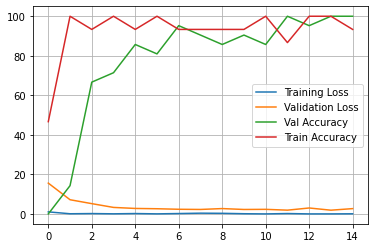

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation Loss")
plt.plot(val_acc, label = 'Val Accuracy')
plt.plot(train_acc, label = 'Train Accuracy')
plt.grid()
plt.legend()
plt.show()
plt.close()

<a id="7"></a>
## <span style="color:#1F618D;">Evaluation on test set</span>

In [10]:
test_set = get_dataloaders(path='Mask_Data/test', training=False)
with torch.no_grad():
        test_loss = 0
        model.eval()
        for batch in test_set:
            test_input, test_labels = batch
            preds = model.forward(test_input)
            _, test_preds = torch.max(preds, dim=1)
            
            test_accuracy = calculate_accuracy(y_true = test_labels, y_pred = test_preds)
print("Test Set Accuracy",test_accuracy)

Test Set Accuracy 92.0
